In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
import json
from PIL import Image
from IPython.display import display
sns.reset_orig()
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from catalogue import load_catalogue

In [2]:
# Set the output directories here
outdirs_1 = [
    ('outdir_b_all_cauchy', 'log_evidence'),
    ('outdir_b_all_equad50', 'log_evidence'),
    # ('outdir_b_all_equad100', 'log_evidence'),
    ('outdir_b_all_eflq50', 'log_evidence'),
    # ('outdir_b_all_eflq100', 'log_evidence'),
    ('outdir_a_all', 'aic'),
]

outdirs_2 = [
    ('outdir_b_img_cauchy', 'log_evidence'),
    ('outdir_b_img_equad50', 'log_evidence'),
    # ('outdir_b_img_equad100', 'log_evidence'),
    ('outdir_b_img_eflq50', 'log_evidence'),
    # ('outdir_b_img_eflq100', 'log_evidence'),
    ('outdir_a_img', 'aic'),
]

In [3]:
def results_from_outdirs(outdirs):
    results, param_ests = [], []
    for outdir, var in outdirs:
        with open(f'../output/results_param_estimates_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
            param_est = json.load(f)
        with open(f'../output/results_{var}_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
            result = pd.DataFrame(json.load(f)).T
            result['best_fitting'] = result.idxmin(axis=1) if var == 'aic' else result.idxmax(axis=1)
            # Remove bad fits
            no_best_fit = open(f'../output/{outdir}/bad_fits.txt', 'r', encoding='utf-8-sig').read().strip().splitlines()
            no_best_fit_filtered = [p for p in no_best_fit if p in result.index]
            result.loc[no_best_fit_filtered, 'best_fitting'] = '(Unclassified)'
            
        print(f'{outdir}:')
        catalogue = load_catalogue(outdirs[0][0])
        print(f' - Number of pulsars in the catalogue: {len(catalogue)}')
        str1, str2 = '', ''
        for n in range(4, 7):
            str1 += f', {n}'
            str2 += f', {len(catalogue.at_least_n_points(n))}'
        str1 = str1[2:]
        str2 = str2[2:]
        print(f' - Number of pulsars with at least {str1} measurements: {str2}')
        print(f' - Number of pulsars reaching fitting requirements: {len(result)}')
        results.append(result)
        param_ests.append(param_est)
    return results, param_ests

In [4]:
model_names = ['simple_power_law', 'broken_power_law', 'log_parabolic_spectrum', 'high_frequency_cut_off_power_law', 'low_frequency_turn_over_power_law', 'double_turn_over_spectrum', '(Unclassified)']
model_names_c = ['simple power law', 'broken power law', 'log-parabolic spectrum', 'high-frequency cut-off power law', 'low-frequency turn-over power law', 'double turn-over spectrum', '(Unclassified)']
model_names_b = ['simple\npower law', 'broken\npower law', 'log-parabolic\nspectrum', 'high-frequency\ncut-off power law', 'low-frequency\nturn-over power law', 'double\nturn-over spectrum', '(Unclassified)']
model_name_cap = lambda x: np.array([model_names_c[model_names.index(m)] for m in x])
model_name_br = lambda x: np.array([model_names_c[model_names.index(m)] for m in x])
def bar_chart(outdirs, save_path=None):
    results, _ = results_from_outdirs(outdirs)
    rx, ry = [], []
    r_total = []
    for r in results:
        rx_i = r['best_fitting'].value_counts().index.to_numpy()
        ry_i = r['best_fitting'].value_counts().to_numpy()
        rx.append(rx_i)
        ry.append(ry_i)
        r_total.append(len(r))
    
    # move unclassified to the end
    if '(Unclassified)' in rx[0]:
        idx = np.where(rx[0] == '(Unclassified)')[0][0]
        rx[0] = np.concatenate([rx[0][:idx], rx[0][idx+1:], [rx[0][idx]]])
        ry[0] = np.concatenate([ry[0][:idx], ry[0][idx+1:], [ry[0][idx]]])
    
    # sort by rx[0]
    N = len(rx)
    # add the missing model names to rx[0]
    rx_0_missing = [model for model in model_names if model not in rx[0]]
    rx[0] = np.concatenate([rx[0], rx_0_missing])
    ry[0] = np.concatenate([ry[0], np.zeros(len(rx_0_missing))])
    for i in range(1, N):
        # add the missing model names to rest of the rx
        for j, model in enumerate(rx[0]):
            if model not in rx[i]:
                rx[i] = np.insert(rx[i], j, model)
                ry[i] = np.insert(ry[i], j, 0)
                
        rx[i], ry[i] = zip(*sorted(zip(rx[i], ry[i]), key=lambda x: rx[0].tolist().index(x[0])))
    
    df_dict = {
        'Model': model_name_cap(rx[0]).tolist(),
    }
    for i, (x, y, total) in enumerate(zip(rx, ry, r_total)):
        df_dict[outdirs[i][0]] = [f'{v:.0f} / {total} ({v/total*100:.1f}%)' for v in y]
    display(pd.DataFrame(df_dict))
    
    r_bf_dict = {}
    r_bf_gt5_dict = {}
    r_bf_total = {}
    for r, outdir_var in zip(results, outdirs):
        outdir, var = outdir_var
        if var == 'aic':
            continue
        r = r[r['best_fitting'] != '(Unclassified)']  # Remove unclassified pulsars
        r_bf = r.drop(columns='best_fitting').sub(r['simple_power_law'], axis=0).drop(columns='simple_power_law')
        r_bf_dict[outdir] = r_bf
        r_bf_gt5_dict[outdir] = (r_bf > 3).sum()
        r_bf_total[outdir] = len(r)
        
    # sort by the first method
    r_bf_gt5 = pd.DataFrame(r_bf_gt5_dict)
    
    r_bf_gt5.loc['(Any ln BF > 3)'] = [(r_bf > 3).any(axis=1).sum() for r_bf in r_bf_dict.values()]
    r_bf_gt5.loc['(All ln BF < -3)'] = [(r_bf < -3).all(axis=1).sum() for r_bf in r_bf_dict.values()]
    
    # change the values to {} / {} = {}% format
    for col in r_bf_gt5.columns:
        r_bf_gt5[col] = [f'{r_bf_gt5[col][i]:.0f} / {r_bf_total[col]} ({r_bf_gt5[col][i]/r_bf_total[col]*100:.1f}%)' for i in r_bf_gt5.index]
    display(r_bf_gt5)
    
    fig, ax = plt.subplots(figsize=(24, 4))
    
    bar_width = 1 / (N + 1)
    bar_positions = np.arange(len(rx[0]))
    
    colors = sns.color_palette('icefire', N)
    for i, (x, y, total) in enumerate(zip(rx, ry, r_total)):
        ax.bar(bar_positions + bar_width * (i - N / 2), y, bar_width, label=outdirs[i][0], color=colors[i])
        labels = [f'{v:.0f}\n{v/total*100:.1f}%' for v in y]
        for j, label in enumerate(labels):
            ax.text(j + bar_width * (i - N / 2), y[j] + 1, label, ha='center', va='bottom', fontsize=9)
    
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(model_name_br(rx[0]))
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

outdir_b_all_cauchy:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882
outdir_b_all_equad50:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 868
outdir_b_all_eflq50:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882
outdir_a_all:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882


,Model,outdir_b_all_cauchy,outdir_b_all_equad50,outdir_b_all_eflq50,outdir_a_all
0,broken power law,281 / 882 (31.9%),255 / 868 (29.4%),476 / 882 (54.0%),254 / 882 (28.8%)
1,simple power law,206 / 882 (23.4%),278 / 868 (32.0%),93 / 882 (10.5%),212 / 882 (24.0%)
2,low-frequency turn-over power law,174 / 882 (19.7%),207 / 868 (23.8%),95 / 882 (10.8%),55 / 882 (6.2%)
3,double turn-over spectrum,72 / 882 (8.2%),44 / 868 (5.1%),67 / 882 (7.6%),26 / 882 (2.9%)
4,log-parabolic spectrum,46 / 882 (5.2%),59 / 868 (6.8%),28 / 882 (3.2%),152 / 882 (17.2%)
5,high-frequency cut-off power law,19 / 882 (2.2%),17 / 868 (2.0%),18 / 882 (2.0%),77 / 882 (8.7%)
6,(Unclassified),84 / 882 (9.5%),8 / 868 (0.9%),105 / 882 (11.9%),106 / 882 (12.0%)


,outdir_b_all_cauchy,outdir_b_all_equad50,outdir_b_all_eflq50
broken_power_law,302 / 798 (37.8%),241 / 860 (28.0%),583 / 777 (75.0%)
double_turn_over_spectrum,245 / 798 (30.7%),173 / 860 (20.1%),462 / 777 (59.5%)
high_frequency_cut_off_power_law,151 / 798 (18.9%),107 / 860 (12.4%),426 / 777 (54.8%)
log_parabolic_spectrum,260 / 798 (32.6%),217 / 860 (25.2%),504 / 777 (64.9%)
low_frequency_turn_over_power_law,276 / 798 (34.6%),232 / 860 (27.0%),480 / 777 (61.8%)
(Any ln BF > 3),339 / 798 (42.5%),273 / 860 (31.7%),589 / 777 (75.8%)
(All ln BF < -3),0 / 798 (0.0%),0 / 860 (0.0%),0 / 777 (0.0%)


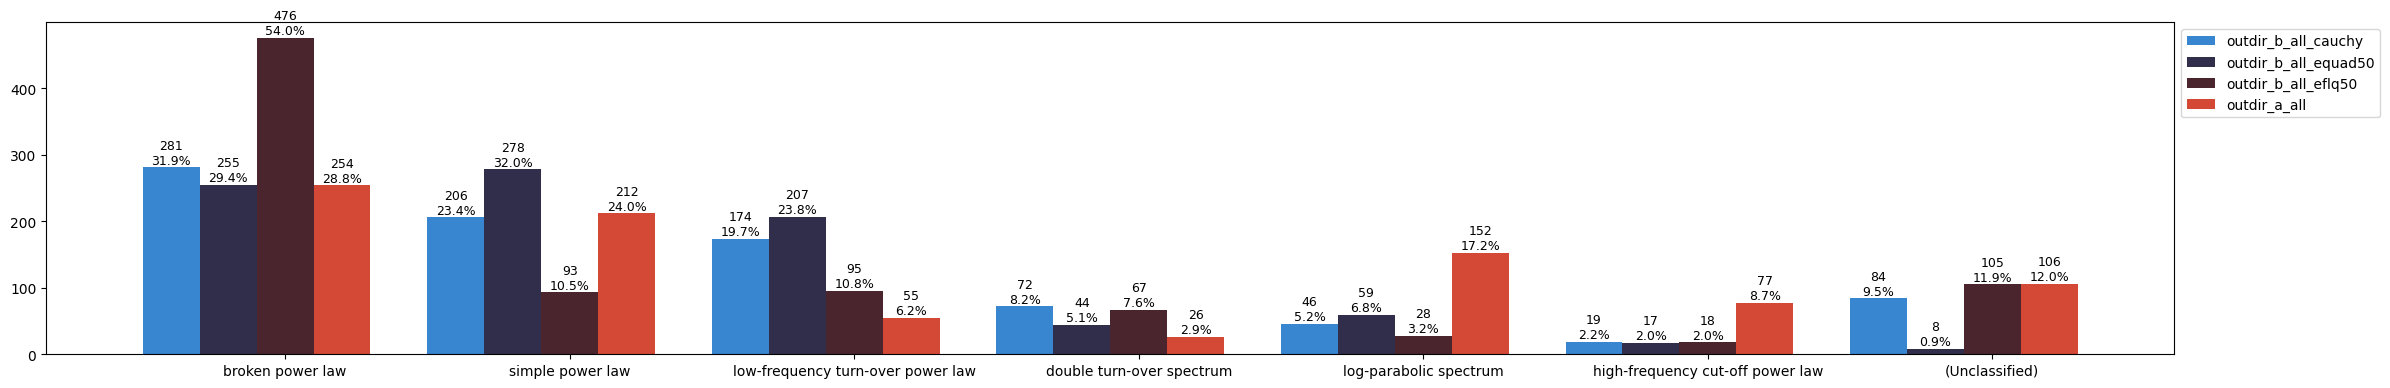

In [5]:
bar_chart(outdirs_1, 'bar_chart_1.png')

outdir_b_img_cauchy:
 - Number of pulsars in the catalogue: 425
 - Number of pulsars with at least 4, 5, 6 measurements: 36, 21, 14
 - Number of pulsars reaching fitting requirements: 36
outdir_b_img_equad50:
 - Number of pulsars in the catalogue: 425
 - Number of pulsars with at least 4, 5, 6 measurements: 36, 21, 14
 - Number of pulsars reaching fitting requirements: 36
outdir_b_img_eflq50:
 - Number of pulsars in the catalogue: 425
 - Number of pulsars with at least 4, 5, 6 measurements: 36, 21, 14
 - Number of pulsars reaching fitting requirements: 36
outdir_a_img:
 - Number of pulsars in the catalogue: 425
 - Number of pulsars with at least 4, 5, 6 measurements: 36, 21, 14
 - Number of pulsars reaching fitting requirements: 36


,Model,outdir_b_img_cauchy,outdir_b_img_equad50,outdir_b_img_eflq50,outdir_a_img
0,low-frequency turn-over power law,12 / 36 (33.3%),11 / 36 (30.6%),10 / 36 (27.8%),1 / 36 (2.8%)
1,simple power law,11 / 36 (30.6%),10 / 36 (27.8%),3 / 36 (8.3%),20 / 36 (55.6%)
2,broken power law,8 / 36 (22.2%),12 / 36 (33.3%),18 / 36 (50.0%),6 / 36 (16.7%)
3,high-frequency cut-off power law,2 / 36 (5.6%),2 / 36 (5.6%),2 / 36 (5.6%),2 / 36 (5.6%)
4,double turn-over spectrum,2 / 36 (5.6%),1 / 36 (2.8%),3 / 36 (8.3%),0 / 36 (0.0%)
5,log-parabolic spectrum,1 / 36 (2.8%),0 / 36 (0.0%),0 / 36 (0.0%),7 / 36 (19.4%)
6,(Unclassified),0 / 36 (0.0%),0 / 36 (0.0%),0 / 36 (0.0%),0 / 36 (0.0%)


,outdir_b_img_cauchy,outdir_b_img_equad50,outdir_b_img_eflq50
broken_power_law,8 / 36 (22.2%),3 / 36 (8.3%),25 / 36 (69.4%)
double_turn_over_spectrum,6 / 36 (16.7%),3 / 36 (8.3%),15 / 36 (41.7%)
high_frequency_cut_off_power_law,4 / 36 (11.1%),3 / 36 (8.3%),16 / 36 (44.4%)
log_parabolic_spectrum,6 / 36 (16.7%),2 / 36 (5.6%),20 / 36 (55.6%)
low_frequency_turn_over_power_law,9 / 36 (25.0%),4 / 36 (11.1%),20 / 36 (55.6%)
(Any ln BF > 3),11 / 36 (30.6%),5 / 36 (13.9%),25 / 36 (69.4%)
(All ln BF < -3),0 / 36 (0.0%),0 / 36 (0.0%),0 / 36 (0.0%)


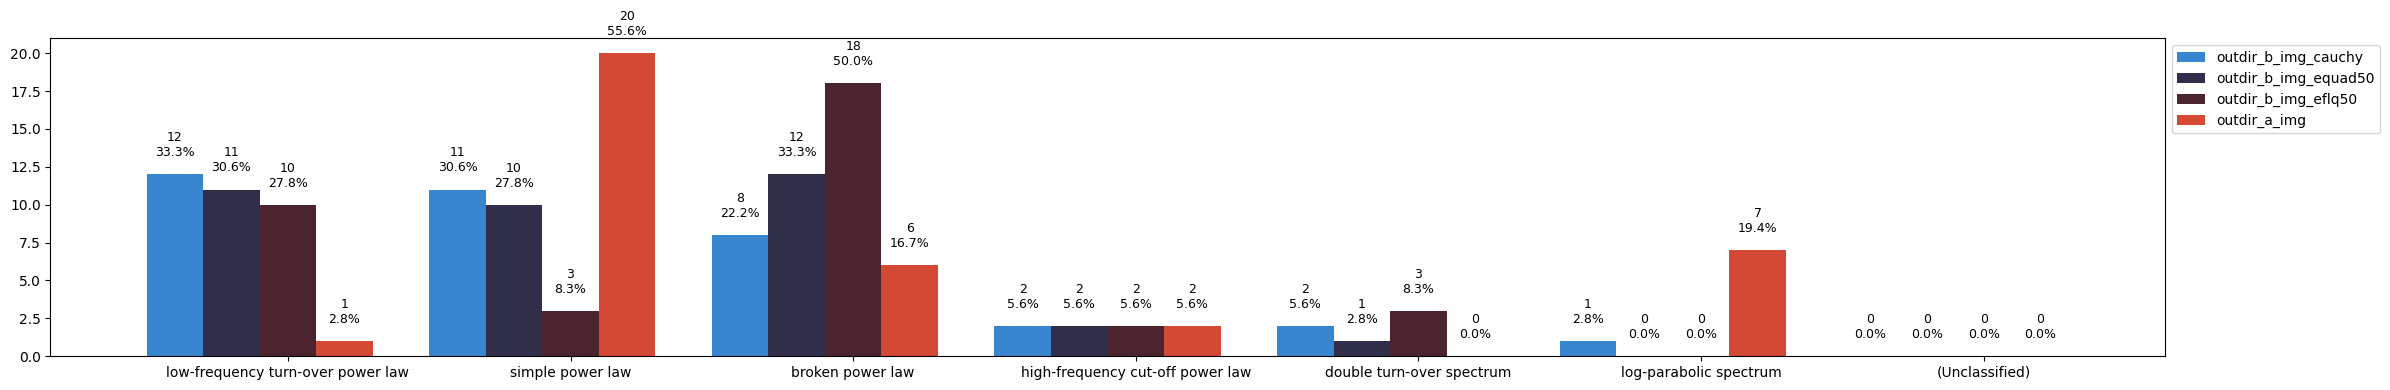

In [6]:
bar_chart(outdirs_2, 'bar_chart_2.png')

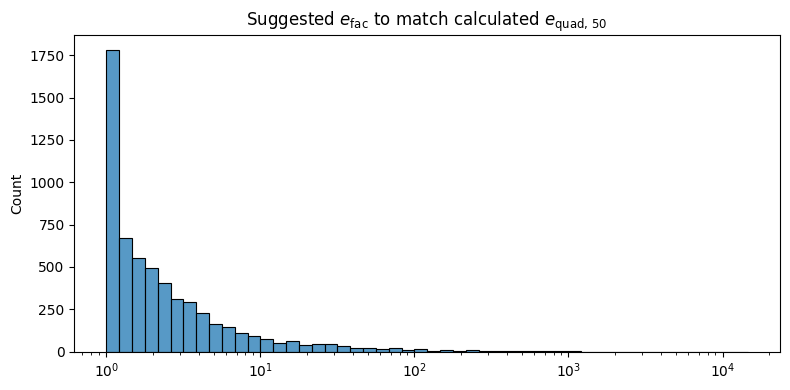

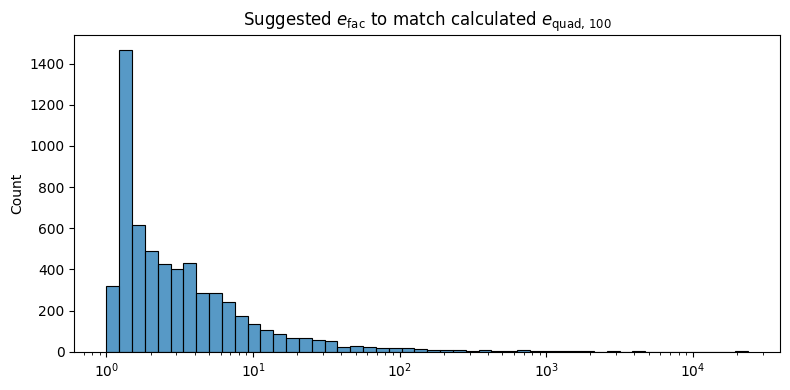

In [12]:
catalogue = load_catalogue(outdirs_1[2][0])
cat_by_jname_ref = catalogue.by_jname_ref()

for T in [50, 100]:
    results_equad = json.load(open(f'../output/results_log_evidence_from_outdir_b_all_equad{T}.json', 'r', encoding='utf-8-sig'))
    param_equad = json.load(open(f'../output/results_params_from_outdir_b_all_equad{T}.json', 'r', encoding='utf-8-sig'))
    pest_equad = json.load(open(f'../output/results_param_estimates_from_outdir_b_all_equad{T}.json', 'r', encoding='utf-8-sig'))
    ratios_equad = []
    
    for jname, rest, param, pest in zip(results_equad.keys(), results_equad.values(), param_equad.values(), pest_equad.values()):
        best_model = max(rest, key=rest.get)
        param_best = param[best_model]
        pest_best = pest[best_model]['median']
        param2est = {k.removeprefix('e_{\mathrm{quad,\,').removesuffix('}}').replace('\_', '_'): v for k, v in zip(param_best, pest_best)}
        
        for ref, data in cat_by_jname_ref[jname].items():
            x, y, yerr = data['X'], data['Y'], data['YERR']
            k_idx = np.argmin(np.array(yerr) / np.array(y))
            k_y, k_yerr = y[k_idx], yerr[k_idx]
            old_yerr_y = k_yerr / k_y
            new_yerr_y = np.sqrt(old_yerr_y**2 + param2est[ref]**2)
            ratios_equad.append(new_yerr_y / old_yerr_y)
            
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.histplot(ratios_equad, log_scale=True, bins=50, ax=ax)
    ax.set_title('Suggested $e_{\mathrm{fac}}$ to match calculated $e_{\mathrm{quad,\,' + str(T) + '}}$')
    plt.tight_layout()
    plt.show()

In [5]:
SHOW_PLOTS = False
if SHOW_PLOTS:
    def get_plots(jname: str, models: list) -> bool:
        images = []
        outdirs = [outdir_st, outdir_aic]
        for i, outdir in enumerate(outdirs):
            file_path = f'../output/{outdir}/{jname}/{models[i]}_result.png'
            if not os.path.exists(file_path):
                continue
            images.append(Image.open(file_path))
        if len(images) < 2:
            return False
        else:
            Image.fromarray(np.hstack([np.array(image) for image in images])).show()
            return True
            
    aic_comp = results_aic[results_aic['best_fitting'] != '(Unclassified)'].drop(columns='best_fitting').sub(results_aic['simple_power_law'], axis=0).drop(columns='simple_power_law')
    aic_comp = aic_comp.dropna(how='all')
    aic_comp = aic_comp.loc[aic_comp.max(axis=1).sort_values(ascending=True).index]
    
    # add a column for corresponding best_fitting in results_st
    aic_comp['best_fitting'] = results_st.loc[aic_comp.index, 'best_fitting']
    
    cnt = 0
    id = 0
    while cnt < 5:
        ret = get_plots(aic_comp.index[id], [aic_comp['best_fitting'][id], 'simple_power_law'])
        id += 1
        if ret:
            cnt += 1

Number of pulsars with at least 10 flux density measurements: 724
Best-fitting classification by the 3 methods:


,Model,Bayesian,Corrected AIC,Uncorrected AIC
0,broken power law,351 / 724 (48.5%),229 / 724 (31.6%),268 / 724 (37.0%)
1,low-frequency turn-over power law,84 / 724 (11.6%),42 / 724 (5.8%),49 / 724 (6.8%)
2,simple power law,75 / 724 (10.4%),110 / 724 (15.2%),66 / 724 (9.1%)
3,double turn-over spectrum,67 / 724 (9.3%),35 / 724 (4.8%),58 / 724 (8.0%)
4,log-parabolic spectrum,38 / 724 (5.2%),145 / 724 (20.0%),134 / 724 (18.5%)
5,high-frequency cut-off power law,18 / 724 (2.5%),72 / 724 (9.9%),58 / 724 (8.0%)
6,(Unclassified),91 / 724 (12.6%),91 / 724 (12.6%),91 / 724 (12.6%)


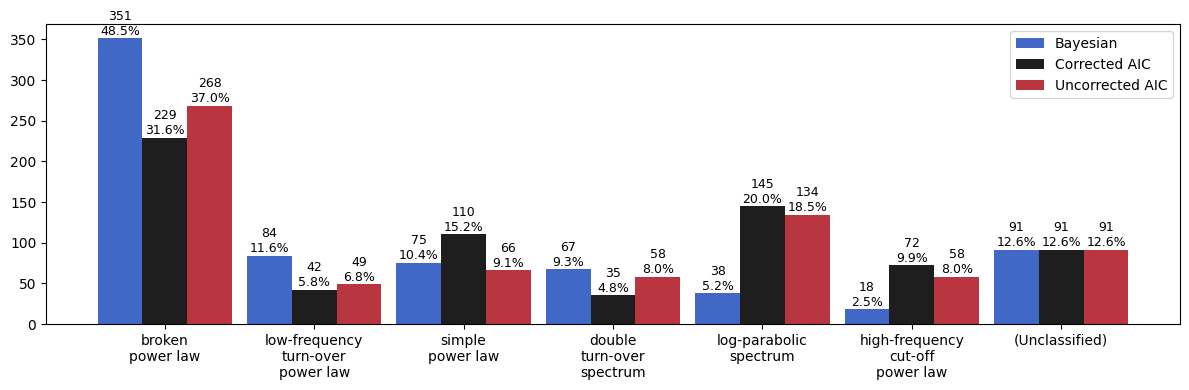

Ln Bayes factors greater than 5 (versus simple power law):


,Bayesian
broken_power_law,437 / 724 (60.4%)
log_parabolic_spectrum,333 / 724 (46.0%)
low_frequency_turn_over_power_law,333 / 724 (46.0%)
double_turn_over_spectrum,331 / 724 (45.7%)
high_frequency_cut_off_power_law,256 / 724 (35.4%)
(Any ln BF > 5),445 / 724 (61.5%)
(All ln BF < -5),0 / 724 (0.0%)


In [6]:
# At least 10 points

ten_points = catalogue.at_least_n_points(10)
ten_points = [p for p in ten_points if p in results_st.index]
results_st_10 = results_st.loc[ten_points]
results_aic_10 = results_aic.loc[ten_points]
results_aw_10 = results_aw.loc[ten_points]
print(f'Number of pulsars with at least 10 flux density measurements: {len(ten_points)}')

best_fitting_classification(results_st_10, results_aic_10, results_aw_10)
ln_bayes_factors_greater_than_five(results_st_10)

Number of MSPs in the catalogue: 176 / 2299 (7.7%)
Number of MSPs in the catalogue with fitting results: 85 / 876 (9.7%)
Number of MSPs in the catalogue with at least 10 flux density measurements: 72 / 724 (9.9%)
Best-fitting classification by the 3 methods:


,Model,Bayesian,Corrected AIC,Uncorrected AIC
0,broken power law,33 / 85 (38.8%),24 / 85 (28.2%),30 / 85 (35.3%)
1,simple power law,24 / 85 (28.2%),26 / 85 (30.6%),14 / 85 (16.5%)
2,low-frequency turn-over power law,15 / 85 (17.6%),3 / 85 (3.5%),4 / 85 (4.7%)
3,log-parabolic spectrum,4 / 85 (4.7%),22 / 85 (25.9%),24 / 85 (28.2%)
4,double turn-over spectrum,4 / 85 (4.7%),1 / 85 (1.2%),4 / 85 (4.7%)
5,high-frequency cut-off power law,4 / 85 (4.7%),8 / 85 (9.4%),8 / 85 (9.4%)
6,(Unclassified),1 / 85 (1.2%),1 / 85 (1.2%),1 / 85 (1.2%)


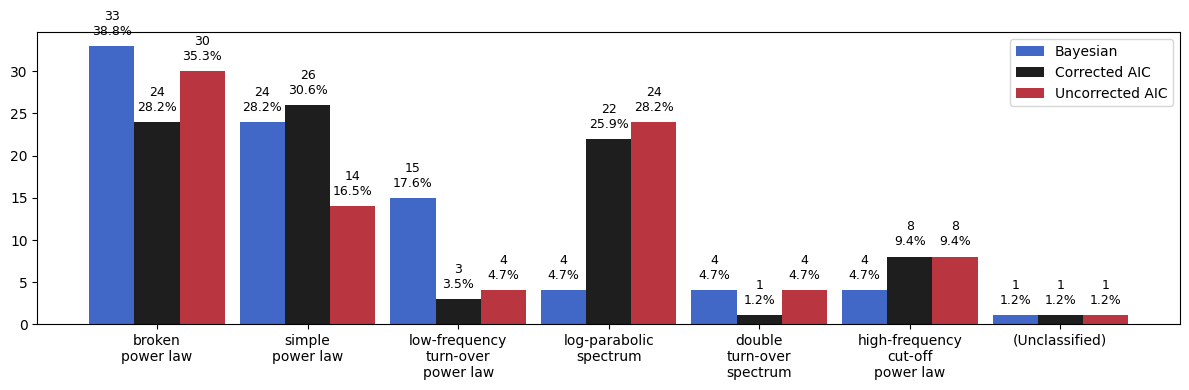

Ln Bayes factors greater than 5 (versus simple power law):


,Bayesian
broken_power_law,43 / 85 (50.6%)
low_frequency_turn_over_power_law,36 / 85 (42.4%)
log_parabolic_spectrum,35 / 85 (41.2%)
double_turn_over_spectrum,30 / 85 (35.3%)
high_frequency_cut_off_power_law,26 / 85 (30.6%)
(Any ln BF > 5),43 / 85 (50.6%)
(All ln BF < -5),0 / 85 (0.0%)


Best-fitting classification by the 3 methods:


,Model,Bayesian,Corrected AIC,Uncorrected AIC
0,broken power law,360 / 791 (45.5%),213 / 791 (26.9%),265 / 791 (33.5%)
1,simple power law,104 / 791 (13.1%),176 / 791 (22.3%),104 / 791 (13.1%)
2,low-frequency turn-over power law,93 / 791 (11.8%),39 / 791 (4.9%),45 / 791 (5.7%)
3,double turn-over spectrum,71 / 791 (9.0%),34 / 791 (4.3%),58 / 791 (7.3%)
4,log-parabolic spectrum,36 / 791 (4.6%),147 / 791 (18.6%),139 / 791 (17.6%)
5,high-frequency cut-off power law,18 / 791 (2.3%),73 / 791 (9.2%),71 / 791 (9.0%)
6,(Unclassified),109 / 791 (13.8%),109 / 791 (13.8%),109 / 791 (13.8%)


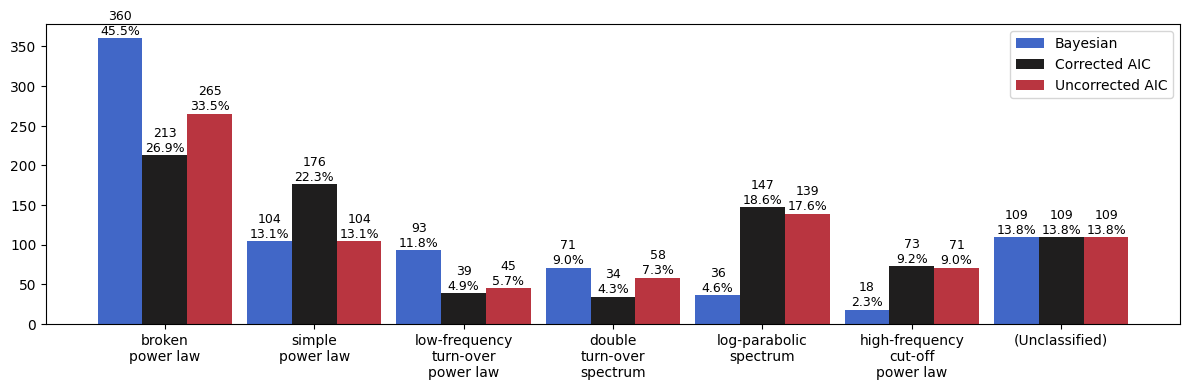

Ln Bayes factors greater than 5 (versus simple power law):


,Bayesian
broken_power_law,418 / 791 (52.8%)
double_turn_over_spectrum,320 / 791 (40.5%)
low_frequency_turn_over_power_law,319 / 791 (40.3%)
log_parabolic_spectrum,317 / 791 (40.1%)
high_frequency_cut_off_power_law,243 / 791 (30.7%)
(Any ln BF > 5),429 / 791 (54.2%)
(All ln BF < -5),0 / 791 (0.0%)


In [7]:
msp_list = catalogue.MSPs
print(f'Number of MSPs in the catalogue: {len(msp_list)} / {len(catalogue)} ({len(msp_list)/len(catalogue)*100:.1f}%)')
# Remove MSPs not in the results
msp_list = [msp for msp in msp_list if msp in results_st.index]
print(f'Number of MSPs in the catalogue with fitting results: {len(msp_list)} / {len(results_st.index)} ({len(msp_list)/len(results_st.index)*100:.1f}%)')
open('../catalogue/msps.txt', 'w', encoding='utf-8-sig').write('\n'.join(msp_list))
msp_list_10 = [msp for msp in msp_list if msp in ten_points]
print(f'Number of MSPs in the catalogue with at least 10 flux density measurements: {len(msp_list_10)} / {len(ten_points)} ({len(msp_list_10)/len(ten_points)*100:.1f}%)')

results_st_msp = results_st.loc[msp_list]
results_aic_msp = results_aic.loc[msp_list]
results_aw_msp = results_aw.loc[msp_list]

best_fitting_classification(results_st_msp, results_aic_msp, results_aw_msp)
ln_bayes_factors_greater_than_five(results_st_msp)

results_st_not_msp = results_st.loc[~results_st.index.isin(msp_list)]
results_aic_not_msp = results_aic.loc[~results_aic.index.isin(msp_list)]
results_aw_not_msp = results_aw.loc[~results_aw.index.isin(msp_list)]

best_fitting_classification(results_st_not_msp, results_aic_not_msp, results_aw_not_msp)
ln_bayes_factors_greater_than_five(results_st_not_msp)